In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/blaubach/chimes_CGD-myLLFork/dissimilarity_clustering


In [3]:
# Get the current working directory
cwd = os.getcwd()

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list

# Display the DataFrame with the new column
print(df_fingerprints.head())


training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)
       2B_0      2B_1      2B_2      2B_3      2B_4      2B_5      2B_6  \
0  0.151940  0.079974  0.039987  0.134957  0.000000  0.039987  0.000000   
1  0.151838  0.089548  0.030670  0.107863  0.026939  0.039628  0.000530   
2  0.152059  0.091794  0.027968  0.104630  0.029103  0.039305  0.001128   
3  0.113888  0.093885  0.074372  0.063481  0.048075  0.037675  0.033869   
4  0.118745  0.094125  0.073008  0.061039  0.048168  0.036493  0.032401   

       2B_7      2B_8      2B_9  ...  4B_54  4B_55  4B_56  4B_57  4B_58  \
0  0.059981  0.000000  0.064979  ...    0.0    0.0    0.0    0.0    0.0   
1  0.059527  0.008709  0.053400  ...    0.0    0.0    0.0    0.0    0.0   
2  0.058054  0.005966  0.057973  ...    0.0    0.0    0.0    0.0    0.0   
3  0.031662  0.025958  0.021373  ...    0.0    0.0    0.0    0.0    0.

(300, 184)


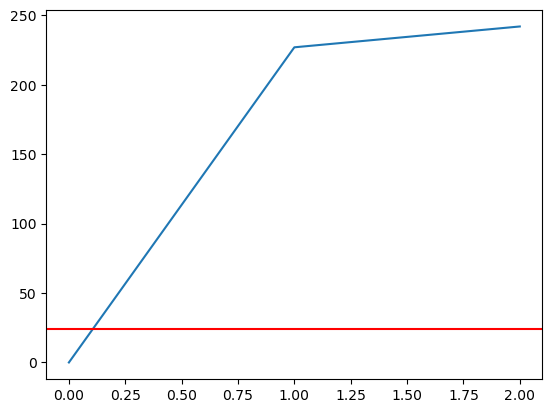

In [4]:
# Initialize the minimum occurrence count required
def compute_pij(phi1, phi2):

    # Compute statistics for training set
    phi1_fingerprint = phi1.iloc[:-4]
    avg_phi1 = phi1.iloc[-3]
    std_phi1 = phi1.iloc[-2]
    natoms_phi1 = float(phi1.iloc[-1])

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4]
    avg_phi2 = phi2.iloc[-3]
    std_phi2 = phi2.iloc[-2]
    natoms_phi2 = float(phi2.iloc[-1])

    # Standardize Natoms
    natoms = np.sqrt(natoms_phi1*natoms_phi2)

    # Compute pij
    numerator = np.sum((phi1_fingerprint-avg_phi1)*(phi2_fingerprint-avg_phi2))
    denominator = natoms*std_phi1*std_phi2
    pij = numerator/denominator

    return pij

def construct_comparison(training_set, candidates, master_matrix, pij_matrix=None, weight=1):
    column_values = training_set.index.tolist()
    if pij_matrix is None:
        pij_matrix = pd.DataFrame(columns = column_values)
    #pij_matrix.columns = column_values
    #pij_matrix[column_values[-1]] = 0
    #pij_matrix = pd.concat([pij_matrix, pd.DataFrame({column_values[-1]: [0] * len(pij_matrix)})], axis=1)

    pij_values = []
    phi1 = training_set.iloc[-1]
    candidates.fillna(0, inplace=True)
    for index_ac, phi2 in candidates.iterrows():
        pij_values.append(compute_pij(phi1, phi2))
    pij_matrix[column_values[-1]] = [x * weight for x in pij_values]

    # Calculate the sum of values in each row and store the results in a list
    sums = pij_matrix.mean(axis=1)

    min_pij_index = sums.idxmin()
    #print("Frame with the minimum Pij sum:", min_pij_index)
    pij_matrix[column_values[-1]] = pij_values

    update_training, update_configurations, update_pij_matrix = update_configuration_sets(min_pij_index, training_set, candidates, pij_matrix)

    # print(np.shape(update_training))
    # print(np.shape(update_configurations))
    # print("###")
    
    return update_training, update_configurations, update_pij_matrix

def update_configuration_sets(min_pij_index, training_set, configuration_set, pij_matrix):
    training_set = pd.concat([training_set, pd.DataFrame([configuration_set.loc[min_pij_index]])])
    pij_matrix = pij_matrix.drop(min_pij_index)
    configuration_set.drop(min_pij_index, inplace=True)
    #configuration_set.reset_index(drop=True, inplace=True)  # Resetting indices without reindexing
    return training_set, configuration_set, pij_matrix

print(np.shape(df_fingerprints))

# Choose arbitrary starting point
starting_frame = 0
phi1 = df_fingerprints.iloc[starting_frame]
phi1_fingerprint = phi1.iloc[:-4]
avg_phi1 = phi1.iloc[-3]
std_phi1 = phi1.iloc[-2]
natoms_phi1 = float(phi1.iloc[-1])

# Initialize training set
current_training_set = pd.DataFrame(columns=df_fingerprints.columns)
current_training_set = pd.concat([current_training_set, pd.DataFrame([phi1])])

# Initialize values:
pij_matrix = None

available_configurations = copy.copy(df_fingerprints)
available_configurations.drop(starting_frame, inplace=True)

# Compute pij matrix
cfg_cnt = 3
for i in range(cfg_cnt-1):
    current_training_set, available_configurations, pij_matrix = construct_comparison(current_training_set, available_configurations, df_fingerprints, pij_matrix)
plt.plot(current_training_set.index)
# Add a horizontal red line at y=24
plt.axhline(y=24, color='red')

# Show the plot
plt.show()


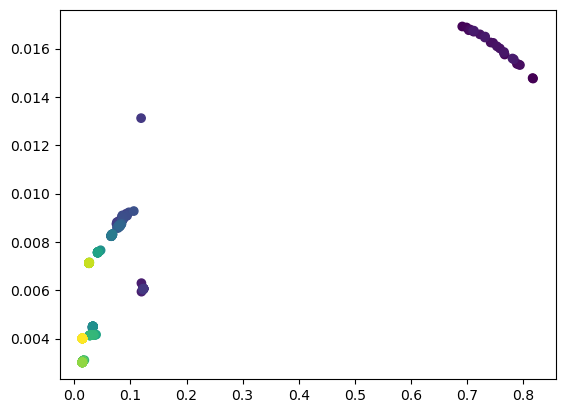

In [8]:
plt.scatter(pij_matrix[0],pij_matrix[227], c=pij_matrix.index)